In [2]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator


In [3]:
from qiskit import transpile

In [4]:
import pylab

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

In [5]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
d = 0.5 #0.735
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, d]], ["H", [0.0, 0.0, 2*d]], ["H", [0.0, 0.0, 3*d]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

In [6]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, LinearMapper, BravyiKitaevMapper

In [7]:
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
#print(second_q_op[0])

/usr/local/lib/python3.10/dist-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


In [8]:
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
#print(qubit_op)
H2_op = qubit_op

In [9]:
"""H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z ) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)"""

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 8


In [10]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[int]],
                              h_coeffs: List[float]) -> np.ndarray:
    """Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    """
    
    dim = 2 ** num_qubits
    num_connections = len(connectivity)
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[c] * np.array(qt.tensor(ops_to_tensor))

    return zz_hamiltonian

In [11]:
num_qubits = H2_op.num_qubits
linkList = []
for i in range(num_qubits-1):
    linkList.append([i,i+1])

coefList = []
for k in range(num_qubits):
    coefList.append(1)
    
hamiltonian = create_zz_hamiltonian(num_qubits, linkList, coefList) 
analog_block = HamiltonianGate(data=hamiltonian, time=2) 

In [12]:
qr = QuantumRegister(num_qubits)
circ = QuantumCircuit(qr)

#circ.x(0)
#circ.h(1)
qbList = []
for v in range(num_qubits):
    qbList.append(qr[v])
    
circ.unitary(analog_block, qbList, label='analog block')
#circ.measure_all()

#As always, we can visualize our circuit using the `QuantumCircuit.draw()` method.
#circ.draw()

In [13]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -6.23932


In [111]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')#, initial_state=circ)

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 

# First we need to define at least one variational parameter
theta = Parameter('a')
psi = Parameter('b')
gamma = Parameter('c')

no_qubits = H2_op.num_qubits

# Create a quantum circuit that is used for the ansatz
ansatz = QuantumCircuit(H2_op.num_qubits) 
# add some single-qubit gates
for i in range(no_qubits-1):
    if i % 2 == 0:
        ansatz.rx(psi, i)
        #ansatz.ry(gamma, i+1)

ansatz.rz(theta, range(no_qubits)) 
ansatz.barrier()
"""
# add a chain of CNOTs (multi-qubit gates)
for i in range(no_qubits-1):
    ansatz.cx(i, i+1)
ansatz.barrier()

    
for i in range(no_qubits-1):
    #ansatz.x(i)
    if i % 2 == 0:
        ansatz.x(i)
        ansatz.h(i+1)
    

for i in reversed(range(no_qubits-1)):
    ansatz.cx(i+1,i)
ansatz.barrier()
"""
    
for i in range(no_qubits-1):
    #ansatz.x(i)
    if i % 2 == 0:
        ansatz.x(i+1)
        ansatz.h(i)

ansatz = ansatz.compose(circ, front=True, inplace=True) 
    

# If you have prepared a state before, you can combine it with your ansatz
# ansatz.compose(prepared_state, front=True, inplace=True)

print(ansatz)

None


In [107]:
optimize = SPSA(maxiter=iterations)#L_BFGS_B(maxiter=iterations)#
#ansatz = transpile(ansatz, backend)

#ansatz.draw()

In [108]:
vqe = VQE(ansatz, optimizer=optimize, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -5.22192
Delta from reference energy value is 1.01740


Text(0.5, 1.0, 'Convergence with no noise')

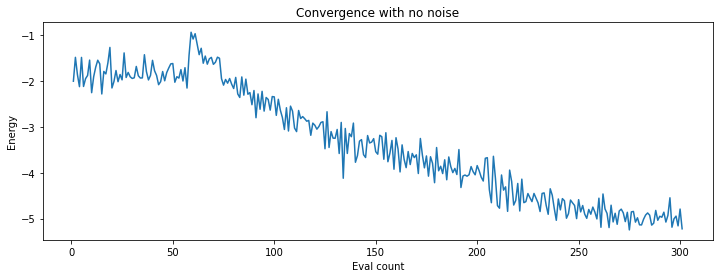

In [109]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise')

In [112]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo, FakeMelbourne
device_backend = FakeMelbourne()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)

#ansatz = transpile(ansatz, backend)
#ansatz.draw()

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['sx', 'id', 'measure', 'cx', 'x']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('sx', (7,)), ('sx', (8,)), ('sx', (9,)), ('sx', (10,)), ('sx', (11,)), ('sx', (12,)), ('sx', (13,)), ('sx', 

In [113]:
#var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
#spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=optimize, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise): -1.72744
Delta from reference energy value is 4.51187


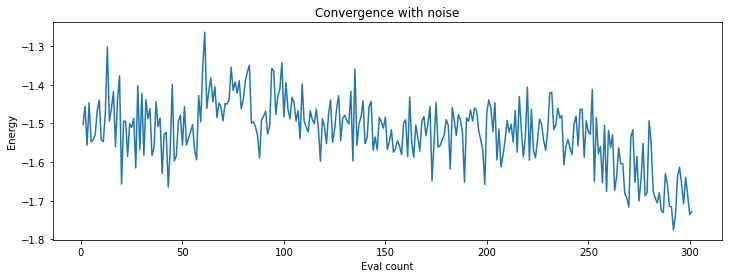

In [114]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

In [ ]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    #ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    #spsa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=optimize, callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H2_op)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

In [ ]:
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled')

In [ ]:
print(f'Reference value: {ref_value:.5f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')